# 뉴스기사 크롤링 분류 프로젝트

In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
# URL 리스트를 만드는 함수 입니다.
# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [3]:
# 결과를 확인할 때 코드로부터 바로 어떤 카테고리인지 확인하기 쉽도록 code를 키, 실제 카테고리를 밸류로 가지는 딕셔너리를 만듭니다.
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [4]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [5]:
code_list = [102, 103, 105]

In [6]:
# make_total_data()  함수는 코드 리스트, 그리고 날짜, 페이지 수를 입력으로 받는아 
# 앞서 만든 make_urllist 함수와 make_data 함수를 호출해 데이터프레임을 만듭니다.

# try except 를 통해 에러메시지를 출력합니다

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [7]:
# print('뉴스 기사의 개수: ',len(df))

In [8]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20231128)

In [9]:
import os

# # 데이터프레임 파일을 csv 파일로 저장합니다.
# # 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
# csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_20231128.csv"
# df.to_csv(csv_path, index=False)

# if os.path.exists(csv_path):
#   print('{} File Saved!'.format(csv_path))

In [10]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_20231128.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,故이예람 중사와 통화 녹취록 요구 '직권남용'? 대법 '무죄' [종합],사회
1,"농어촌공사, 농지은행 사업비 1조8000억…역대 최대",사회
2,여성단체 “흉기 협박 성폭력에 무죄 선고한 국민의힘 공관위원장 규탄”,사회
3,"경찰국 반대했다가 좌천…‘미니스커드 여경’ 이지은 퇴직, 총선행?",사회
4,"용인시, 자치권 확대 위한 조직개편 추진",사회


In [11]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  4203


In [12]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_381/3649439000.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0            이예람 중사와 통화 녹취록 요구 직권남용 대법 무죄 종합
1                     농어촌공사 농지은행 사업비 조억역대 최대
2       여성단체 흉기 협박 성폭력에 무죄 선고한 국민의힘 공관위원장 규탄
3            경찰국 반대했다가 좌천미니스커드 여경 이지은 퇴직 총선행
4                      용인시 자치권 확대 위한 조직개편 추진
                        ...                 
4198             뇌 속 노폐물 청소하는 뇌척수액 배출 경로 찾았다
4199                 전기안전공사 정읍에 전기안전인재개발원 개원
4200             과기정통부 생성  핵심기술 분야 인재양성 추진한다
4201                   과기정통부 제차 퀀텀 스퀘어 미팅 개최
4202         비즈 칼럼 국가 과학기술 데이터 혁신 청룡처럼 날아오르길
Name: news, Length: 4203, dtype: object

In [13]:
print(df.isnull().sum())

news    9
code    0
dtype: int64


In [14]:
# NULL 값이 있는 행을 제거합니다
df.dropna(axis=0, inplace=True)
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [15]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3131


<AxesSubplot:>

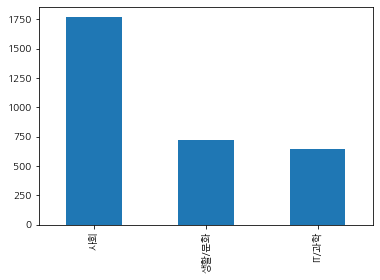

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [17]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    648
1     사회   1766
2  생활/문화    717


In [18]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [19]:
# 불용어 정의
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [35]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [36]:
text_data = preprocessing(df['news'])
print(text_data[0])

예람 중사 와 통화 녹 취록 요구 직권 남용 대법 무죄 종합


In [22]:
# 머신 러닝 모델 적용을 위해서 필요한 도구들을 임포트합니다.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [23]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [24]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2348
테스트용 뉴스 기사의 개수 :  783
훈련용 레이블의 개수 :  2348
테스트용 레이블의 개수 :  783


In [25]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [26]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [27]:
# 테스트를 위한 부분입니다
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [28]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [29]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [30]:
# 예측 및 정확도 분석
y_pred = clf.predict(tfidf_vectorizer(X_test))
precision_matrics = metrics.classification_report(y_test, y_pred)
print(precision_matrics )

              precision    recall  f1-score   support

       IT/과학       0.87      0.60      0.71       169
          사회       0.75      0.98      0.85       451
       생활/문화       0.85      0.42      0.56       163

    accuracy                           0.78       783
   macro avg       0.82      0.66      0.71       783
weighted avg       0.80      0.78      0.76       783



## Step 1. 형태소 분석기 변경해 보기

한국어 자연어 처리에 성능에 영향을 주는 또 다른 요소는 사용하는 형태소 분석기의 종류입니다. 앞서 진행한 프로젝트에서는 Mecab을 사용했었습니다. 하지만 이번에 설치한 konlpy 패키지 안에는 Mecab 이외에도 Hannanum, Kkma, Komoran, Okt 라는 형태소분석기가 존재합니다. 이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.

In [37]:
# 다양한 형태소 분석기 임포트 및 객체 생성

from konlpy.tag import Mecab
mecab = Mecab()

from konlpy.tag import Hannanum
hannanum = Hannanum()

from konlpy.tag import Kkma
kkma = Kkma()

from konlpy.tag import Komoran
komoran = Komoran()

from konlpy.tag import Okt
okt = Okt()

In [38]:
# 앞서 만든 토큰화 및 불용어를 제거하는 함수에 형태소 종류를 추가로 입력받는 함수입니다.
def preprocessing_2(data, tokenizer):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [39]:
# 5개의 형태소 분석기로 전처리 및 불용어 제거
text_data_mecab = preprocessing_2(df['news'], mecab)

In [ ]:
text_data_hannanum = preprocessing_2(df['news'], hannanum)

In [ ]:
text_data_kkma = preprocessing_2(df['news'], kkma)

In [ ]:
text_data_komoran = preprocessing_2(df['news'], komoran)

In [ ]:
text_data_okt  = preprocessing_2(df['news'], okt)

In [ ]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.

X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [ ]:
# 각 형태소 분석기에 대해 머신러닝 분석을 다시 실시합니다

#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 각 형태소 분석기에 대해 예측 및 정확도 분석을 합니다
y_pred = clf.predict(tfidf_vectorizer(X_test))
precision_matrics = metrics.classification_report(y_test, y_pred)
print(precision_matrics )

In [ ]:
# 각 형태소 분석기의 정확도를 비교합니다.


## Step 2. 불용어 추가해 보기

머신 러닝을 하다보면 전처리는 어쩌면 끝이 없는 작업일 수도 있습니다. 불용어 추가도 마찬가지입니다. 데이터를 출력해 보고, 직접 뉴스를 열어보면서 불용어가 총 50개가 될 때까지 추가해 보세요. 그리고 불용어를 추가하기 전, 후의 모델 성능을 비교해 보세요.

지나치게 빈도가 낮은 단어, 지나치게 빈도가 높은 단어 둘 중 어떤 단어가 불용어로 선택할 경우에 모델 성능 향상에 효과가 더 좋을지도 고민해 봅시다.

In [40]:
# 불용어 추가 작성 전
text_data = preprocessing(df['news'])
print(text_data)

['예람 중사 와 통화 녹 취록 요구 직권 남용 대법 무죄 종합', '농어촌 공사 농지 은행 사업비 조억 역대 최대', '여성 단체 흉기 협박 성폭력 무죄 선고 국민 힘 공관 위원장 규탄', '경찰국 반대 다가 좌천 미니 스커드 여경 이지은 퇴직 총 선행', '용인 시 자치 권 확대 위한 조직 개편 추진', '투명 순창 군청 행안 부 정보 공개 평가 년 연속 최우수', '이상찬 전 한국영 상대 교수 대전 서구 갑 총선 도전', '거창 소식 년 산 공공 비축 미곡 해담 삼광 매입', '담양 딸기 몽골 식탁 오른다 중앙아시아 진출 교두보 마련', '충북 증평군 민관 공동 영농 운영 위원회 구성 해 농촌 누빈다', '국민 힘 이정현 광 양곡 성 구례 출마 중진 힘 으로 천지개벽 일으킬 것', '최태원 노소영 이혼 소송 기존 재판부 그대로 진행 한다', '밥 먹 자격 없 초등 생 형제 굶기 고 쇠 자 로 마구 때린 계모', '민간 자동차 검사소 곳 적발 합격 위주 부실 부정 검사 근절', '전 사위 특혜 채용 의혹 최수규 전 중기 부 차관 조사', '대구시 군위군 글로벌 관문 도약 조 투입', '책 평창군 고지도 고 지리지 총람', '매운 음식 못 먹 거 알 면서 청양 고추 때려 넣 시어머니 남편 모른 척', '박형준 가덕 도 신 공항 아시아 복합 물류 세계 대 허브 공항 으로', '하루 시간 매일 공부 해 교사 됐 지만 년 만 퇴직 합니다', '책 일상 속 균열 에서 시작 되 낯선 상상력 세계', '머니 픽 금감원 경찰청 건보 공단 보험 사기 범죄 척결', '호두과자 진심 인 천안 새 전략 세웠 지금', '협회 사랑 열매 기부', '부 고조 임순 씨 별세', '현산 해외 교류 확대 로 안전 품질 경쟁력 강화', '윤용택 센트리 온 홀딩스 회장 명 년 자랑 스러운 성 균 인상', '김진상 경희대 신임 총장', '정충기 토목학 회장 취임', '세 내린 자원입대 결정 내 인생 최고 선택', '기증 받 세한도 점 내일 공개', '이번 엔 스티븐 연 배우 조합 상 남 우주 

In [41]:
# 불용어 정의 추가
stopwords_long = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '서', '봤더니', '지금', '종합', '소식', '것', '부터', '까지', '지역', '세요', '게', '또', '었', '였', '겠', '았', '한다', '아', '우', '으', '오', '이', '헉', '헐', '와', '우와', '오오', '아아', '입니다' ]

In [42]:
print(len(stopwords_long))

60


In [43]:
# 토큰화 및 토큰화 과정에서 추가한 불용어를 포함하여 제거하는 함수입니다
def preprocessing_long(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords_long] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [44]:
text_data_long = preprocessing_long(df['news'])
print(text_data_long)

['예람 중사 통화 녹 취록 요구 직권 남용 대법 무죄', '농어촌 공사 농지 은행 사업비 조억 역대 최대', '여성 단체 흉기 협박 성폭력 무죄 선고 국민 힘 공관 위원장 규탄', '경찰국 반대 다가 좌천 미니 스커드 여경 이지은 퇴직 총 선행', '용인 시 자치 권 확대 위한 조직 개편 추진', '투명 순창 군청 행안 부 정보 공개 평가 년 연속 최우수', '이상찬 전 한국영 상대 교수 대전 서구 갑 총선 도전', '거창 년 산 공공 비축 미곡 해담 삼광 매입', '담양 딸기 몽골 식탁 오른다 중앙아시아 진출 교두보 마련', '충북 증평군 민관 공동 영농 운영 위원회 구성 해 농촌 누빈다', '국민 힘 이정현 광 양곡 성 구례 출마 중진 힘 으로 천지개벽 일으킬', '최태원 노소영 이혼 소송 기존 재판부 그대로 진행', '밥 먹 자격 없 초등 생 형제 굶기 고 쇠 자 로 마구 때린 계모', '민간 자동차 검사소 곳 적발 합격 위주 부실 부정 검사 근절', '전 사위 특혜 채용 의혹 최수규 전 중기 부 차관 조사', '대구시 군위군 글로벌 관문 도약 조 투입', '책 평창군 고지도 고 지리지 총람', '매운 음식 못 먹 거 알 면서 청양 고추 때려 넣 시어머니 남편 모른 척', '박형준 가덕 도 신 공항 아시아 복합 물류 세계 대 허브 공항 으로', '하루 시간 매일 공부 해 교사 됐 지만 년 만 퇴직 합니다', '책 일상 속 균열 에서 시작 되 낯선 상상력 세계', '머니 픽 금감원 경찰청 건보 공단 보험 사기 범죄 척결', '호두과자 진심 인 천안 새 전략 세웠', '협회 사랑 열매 기부', '부 고조 임순 씨 별세', '현산 해외 교류 확대 로 안전 품질 경쟁력 강화', '윤용택 센트리 온 홀딩스 회장 명 년 자랑 스러운 성 균 인상', '김진상 경희대 신임 총장', '정충기 토목학 회장 취임', '세 내린 자원입대 결정 내 인생 최고 선택', '기증 받 세한도 점 내일 공개', '이번 엔 스티븐 연 배우 조합 상 남 우주 연상 후보', '쌍둥이 판다 

In [45]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(text_data_long, df['code'], random_state = 0)

In [46]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts_long = count_vect.fit_transform(X_train_long)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf_long = tfidf_transformer.fit_transform(X_train_counts_long)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf_long = MultinomialNB().fit(X_train_tfidf_long, y_train_long)

In [47]:
# 각 형태소 분석기에 대해 예측 및 정확도 분석을 합니다
y_pred_long = clf.predict(tfidf_vectorizer(X_test_long))
precision_matrics_long = metrics.classification_report(y_test_long, y_pred_long)
print(precision_matrics_long)

ValueError: X has 5605 features, but MultinomialNB is expecting 5614 features as input.

In [48]:
# 불용어를 제거하기 전의 정확도와 비교해봅니다
print(precision_matrics )

              precision    recall  f1-score   support

       IT/과학       0.87      0.60      0.71       169
          사회       0.75      0.98      0.85       451
       생활/문화       0.85      0.42      0.56       163

    accuracy                           0.78       783
   macro avg       0.82      0.66      0.71       783
weighted avg       0.80      0.78      0.76       783



## Step 3. 다른 날짜 데이터 추가해 보기

동일한 날짜에는 그 날 특정 사건이 일어나서 비슷한 뉴스들이 올라왔을 가능성이 많습니다. 사실 좀 더 정확한 모델을 만들기 위해서는 다른 날짜의 뉴스들도 훈련 데이터로 사용하는 것이 좋을 겁니다.

크롤링을 위한 코드는 이미 주어졌습니다. 이제는 2023년 11월 28일 외에도 다른 일자의 데이터를 좀 더 추가해 보겠습니다. 이미 수집한 2023년 11월 28일 데이터와 추가로 수집된 데이터를 적절히 합치려면 어떻게 해야할까요? 또 어떻게 해야 적절히 데이터를 섞을 수 있을까요? 한번 고민해서 데이터를 수집해 보세요.

In [49]:
# 2023년 11월 19일 데이터를 추가합니다
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_20231129.csv"
df_2 = pd.read_table(csv_path, sep=',')
df_2.head()

,news,code
0,안성 칠장사 화재… 자승 前 조계종 총무원장 입적,사회
1,전 조계종 총무원장 자승스님 화재로 사망...사고 전 유서형식 메모남겨,사회
2,"경찰 ""자승 스님 입적한 칠장사 화재 당시 4명 대피""",사회
3,"안성 칠장사에 불...""조계종 전 총무원장 자승스님 입적""",사회
4,"안성 칠장사 화재…조계종 ""자승 전 총무원장 입적""(종합2보)",사회


In [50]:
print('뉴스 기사의 개수: ',len(df_2))

뉴스 기사의 개수:  3910


In [51]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df_2['news'] = df_2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_2['news']

/tmp/ipykernel_381/840130448.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_2['news'] = df_2['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0                  안성 칠장사 화재 자승  조계종 총무원장 입적
1       전 조계종 총무원장 자승스님 화재로 사망사고 전 유서형식 메모남겨
2                경찰 자승 스님 입적한 칠장사 화재 당시 명 대피
3                안성 칠장사에 불조계종 전 총무원장 자승스님 입적
4               안성 칠장사 화재조계종 자승 전 총무원장 입적종합보
                        ...                 
3905           광증 음악가 슈만과 제자 브람스 그들이 사랑한 클라라
3906                 용감한 시민 괴물학교폭력 뒤 어둠을 다루다
3907                              오늘의 운세 월 일
3908                    오늘의 운세 월 일 오늘의 띠별 운세
3909                      오늘의 운세 년 월 일 띠별 운세
Name: news, Length: 3910, dtype: object

In [52]:
print(df_2.isnull().sum())

news    11
code     0
dtype: int64


In [53]:
# NULL 값이 있는 행을 제거합니다
df_2.dropna(axis=0, inplace=True)
print(df_2.isnull().sum())

news    0
code    0
dtype: int64


In [54]:
# 중복된 샘플들을 제거합니다.
df_2.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df_2))

뉴스 기사의 개수:  3325


<AxesSubplot:>

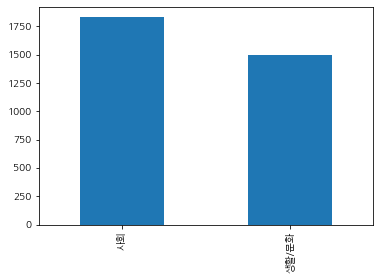

In [55]:
df_2['code'].value_counts().plot(kind = 'bar')

In [56]:
print(df_2.groupby('code').size().reset_index(name = 'count'))

    code  count
0     사회   1828
1  생활/문화   1497


In [57]:
df, df_2

(                                      news   code
 0          이예람 중사와 통화 녹취록 요구 직권남용 대법 무죄 종합     사회
 1                   농어촌공사 농지은행 사업비 조억역대 최대     사회
 2     여성단체 흉기 협박 성폭력에 무죄 선고한 국민의힘 공관위원장 규탄     사회
 3          경찰국 반대했다가 좌천미니스커드 여경 이지은 퇴직 총선행     사회
 4                    용인시 자치권 확대 위한 조직개편 추진     사회
 ...                                    ...    ...
 3950       기체 이온 탄생변화 과정 실시간 포착 숨겨진 비밀 찾았다  IT/과학
 3952               전기안전공사 정읍에 전기안전인재개발원 개원  IT/과학
 3953           과기정통부 생성  핵심기술 분야 인재양성 추진한다  IT/과학
 3954                 과기정통부 제차 퀀텀 스퀘어 미팅 개최  IT/과학
 3955       비즈 칼럼 국가 과학기술 데이터 혁신 청룡처럼 날아오르길  IT/과학
 
 [3131 rows x 2 columns],
                                       news   code
 0                안성 칠장사 화재 자승  조계종 총무원장 입적     사회
 1     전 조계종 총무원장 자승스님 화재로 사망사고 전 유서형식 메모남겨     사회
 2              경찰 자승 스님 입적한 칠장사 화재 당시 명 대피     사회
 3              안성 칠장사에 불조계종 전 총무원장 자승스님 입적     사회
 4             안성 칠장사 화재조계종 자승 전 총무원장 입적종합보     사회
 ...                                    ...    ...
 37

In [58]:
df_all = pd.concat([df, df_2], ignore_index=True)
df_all

,news,code
0,이예람 중사와 통화 녹취록 요구 직권남용 대법 무죄 종합,사회
1,농어촌공사 농지은행 사업비 조억역대 최대,사회
2,여성단체 흉기 협박 성폭력에 무죄 선고한 국민의힘 공관위원장 규탄,사회
3,경찰국 반대했다가 좌천미니스커드 여경 이지은 퇴직 총선행,사회
4,용인시 자치권 확대 위한 조직개편 추진,사회
...,...,...
6451,불을 먹는 괴물새의 출현에 인간들은 혼비백산했다 수요동물원,생활/문화
6452,광증 음악가 슈만과 제자 브람스 그들이 사랑한 클라라,생활/문화
6453,용감한 시민 괴물학교폭력 뒤 어둠을 다루다,생활/문화
6454,오늘의 운세 월 일,생활/문화


In [59]:
print(df_all.isnull().sum())

news    0
code    0
dtype: int64


In [60]:
# 중복된 샘플들을 제거합니다.
df_all.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df_all))

뉴스 기사의 개수:  6441


In [61]:
df_all

,news,code
0,이예람 중사와 통화 녹취록 요구 직권남용 대법 무죄 종합,사회
1,농어촌공사 농지은행 사업비 조억역대 최대,사회
2,여성단체 흉기 협박 성폭력에 무죄 선고한 국민의힘 공관위원장 규탄,사회
3,경찰국 반대했다가 좌천미니스커드 여경 이지은 퇴직 총선행,사회
4,용인시 자치권 확대 위한 조직개편 추진,사회
...,...,...
6449,녹유 오늘의 운세 년생 잘 받은 성적표 상은 덤으로 와요,생활/문화
6450,오늘의 운세 월 일 금전운명예운이 길한 띠는,생활/문화
6451,불을 먹는 괴물새의 출현에 인간들은 혼비백산했다 수요동물원,생활/문화
6452,광증 음악가 슈만과 제자 브람스 그들이 사랑한 클라라,생활/문화


<AxesSubplot:>

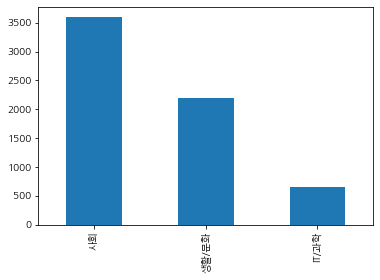

In [62]:
df_all['code'].value_counts().plot(kind = 'bar')

In [63]:
print(df_all.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    648
1     사회   3593
2  생활/문화   2200


In [64]:
text_data_all = preprocessing_long(df_all['news'])
print(text_data_all)

['예람 중사 통화 녹 취록 요구 직권 남용 대법 무죄', '농어촌 공사 농지 은행 사업비 조억 역대 최대', '여성 단체 흉기 협박 성폭력 무죄 선고 국민 힘 공관 위원장 규탄', '경찰국 반대 다가 좌천 미니 스커드 여경 이지은 퇴직 총 선행', '용인 시 자치 권 확대 위한 조직 개편 추진', '투명 순창 군청 행안 부 정보 공개 평가 년 연속 최우수', '이상찬 전 한국영 상대 교수 대전 서구 갑 총선 도전', '거창 년 산 공공 비축 미곡 해담 삼광 매입', '담양 딸기 몽골 식탁 오른다 중앙아시아 진출 교두보 마련', '충북 증평군 민관 공동 영농 운영 위원회 구성 해 농촌 누빈다', '국민 힘 이정현 광 양곡 성 구례 출마 중진 힘 으로 천지개벽 일으킬', '최태원 노소영 이혼 소송 기존 재판부 그대로 진행', '밥 먹 자격 없 초등 생 형제 굶기 고 쇠 자 로 마구 때린 계모', '민간 자동차 검사소 곳 적발 합격 위주 부실 부정 검사 근절', '전 사위 특혜 채용 의혹 최수규 전 중기 부 차관 조사', '대구시 군위군 글로벌 관문 도약 조 투입', '책 평창군 고지도 고 지리지 총람', '매운 음식 못 먹 거 알 면서 청양 고추 때려 넣 시어머니 남편 모른 척', '박형준 가덕 도 신 공항 아시아 복합 물류 세계 대 허브 공항 으로', '하루 시간 매일 공부 해 교사 됐 지만 년 만 퇴직 합니다', '책 일상 속 균열 에서 시작 되 낯선 상상력 세계', '머니 픽 금감원 경찰청 건보 공단 보험 사기 범죄 척결', '호두과자 진심 인 천안 새 전략 세웠', '협회 사랑 열매 기부', '부 고조 임순 씨 별세', '현산 해외 교류 확대 로 안전 품질 경쟁력 강화', '윤용택 센트리 온 홀딩스 회장 명 년 자랑 스러운 성 균 인상', '김진상 경희대 신임 총장', '정충기 토목학 회장 취임', '세 내린 자원입대 결정 내 인생 최고 선택', '기증 받 세한도 점 내일 공개', '이번 엔 스티븐 연 배우 조합 상 남 우주 연상 후보', '쌍둥이 판다 

In [65]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(text_data_all, df_all['code'], random_state = 42)
# train_test_split 함수에 의해 랜덤하게 데이터가 섞입니다

In [66]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts_all = count_vect.fit_transform(X_train_all)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf_all = tfidf_transformer.fit_transform(X_train_counts_all)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf_all = MultinomialNB().fit(X_train_tfidf_all, y_train_all)

In [67]:
# 이틀 치 데이터에 대해 예측 및 정확도 분석을 합니다
y_pred_all = clf_all.predict(tfidf_vectorizer(X_test_all))
precision_matrics_all = metrics.classification_report(y_test_all, y_pred_all)
print(precision_matrics_all)

              precision    recall  f1-score   support

       IT/과학       1.00      0.32      0.48       160
          사회       0.77      0.92      0.84       935
       생활/문화       0.75      0.63      0.69       516

    accuracy                           0.77      1611
   macro avg       0.84      0.62      0.67      1611
weighted avg       0.79      0.77      0.75      1611



In [68]:
# 원래 하루 치 데이터에 대한 예측 및 정확도와 비교해봅니다
print(precision_matrics )

              precision    recall  f1-score   support

       IT/과학       0.87      0.60      0.71       169
          사회       0.75      0.98      0.85       451
       생활/문화       0.85      0.42      0.56       163

    accuracy                           0.78       783
   macro avg       0.82      0.66      0.71       783
weighted avg       0.80      0.78      0.76       783



### 회고

1. 배운 점
- HTML에 대한 기본적인 지식을 익혔다
- bs4와 newspaper3k 패키지를 알게 됐다. 
- 특히 newspaper3k 패키지는 처음 알게 됐는데 뉴스 크롤링 시 굉장히 유용할 것 같다.
- 데이터 전처리에 관해 기본적인 지식을 익혔다.
- 형태소 분석에 관해 기본적인 지식을 익혔다.

2. 아쉬운 점
- 데이터 로딩과 다양한 형태소 분석기 비교에 시간이 오래 걸려서 다양한 형태소 분석기 비교를 완료하지 못했다.
- 나이브 베이즈 분류기보다 더 정확한 모델을 적용해보고 싶었는데 시간이 부족했다.

3. 느낀 점
- 데이터 과학에서는 역시 데이터 수집과 전처리 시간이 가장 많이 소요된다는 점을 느꼈다.